<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Sonion/Sonion_process_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All process in multi weeks

## Prepare data

In [65]:
import datetime
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot
import re

import statistics as st
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [66]:
import glob
#path='/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000'
path='/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan E series 1'
#path='/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan VPU'
path=path+'/'
#print(path)
all_files1=glob.glob(path + '*.xlsx')
all_files2=glob.glob(path + '*.xlsm')
all_files=all_files1+all_files2
#sort file in directory by reverse:
all_files = sorted(all_files, reverse = False)
print('number of files: ',len(all_files))

number of files:  4


In [67]:
all_files

['/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan E series 1/Control Plan data REC E-series 1 - WK33 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan E series 1/Control Plan data REC E-series 1 - WK34 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan E series 1/Control Plan data REC E-series 1 - WK35 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan E series 1/Control Plan data REC E-series 1 - WK36 - 2020.xlsm']

In [107]:
#%%time
import xlrd
all_process_week={}
n=0
for path_name in all_files: # read each excel file
  week_name=path_name[-16:-5]
  xls = xlrd.open_workbook(path_name, on_demand=True)
  sheet_names=xls.sheet_names()
  #print(xls.sheet_names())
  sheet_dict={}
  xls = pd.ExcelFile(path_name) 
  for name in sheet_names: # read each sheet in excel file
    sheet_dict[name] = pd.read_excel(xls, name)
    #sheet_dict[name].to_excel(name+'.xlsx')
  #break
  # Read all process in one week
  sheet_all={} # most important
  sheet_error=[]
  for name_sheet in sheet_names[1:]: # all sheet
    #print(name_sheet)
    sheet=sheet_dict[name_sheet]

    # find begin and end col
    values_col=sheet.iloc[22,:]
    values_col.reset_index(drop=True,inplace=True)
    begin_col=values_col[values_col=='Kích thước\nDimension'].index
    begin_col=begin_col+1
    end_col=values_col[values_col=='MSNV'].index
    #print(begin_col,end_col)
  
    df_dict={} # add all value, USL, LSL, UCL... in sheet
    try:
      for name in sheet.columns[begin_col[0]:end_col[0]]:
        
          df=pd.DataFrame()
          
          #tolerance_dict[sheet[name][22]]=[sheet[name][24],sheet[name][23]]
          df['Date']=sheet[sheet.columns[9]][25:]
          df['Date']=df['Date'].apply(lambda x: x.strftime("%Y %m %d %H"))
          df['Date']=pd.to_datetime(df['Date'])
          #df['Hour']=df['Date'].dt.hour
          df['Value']=sheet[name][25:]
          df['USL']=sheet[name][23] # max
          df['LSL']=sheet[name][24] # min
          df.dropna(subset=['Value'],inplace=True)
          #UCL,LCL,nominal:
          k=3
          df['UCL']=df['Value'].mean() + df['Value'].std()*k
          df['LCL']=df['Value'].mean() - df['Value'].std()*k
          df['Mean']=df['Value'].mean()
          df[df.columns[1:]]=df[df.columns[1:]].astype('float32')
          dim_name=sheet[name][22]
          df_dict[dim_name]=df.reset_index(drop=True)
    except:
      sheet_error.append(name_sheet)
      continue
    sheet_all[name_sheet]=df_dict
  all_process_week[week_name]=sheet_all
  print(week_name,sheet_error)

WK33 - 2020 ['21460-Weld armature']
WK34 - 2020 ['21460-Weld armature']
WK35 - 2020 ['21460-Weld armature']
WK36 - 2020 ['21460-Weld armature']


In [69]:
all_process_week.keys()

dict_keys(['WK33 - 2020', 'WK34 - 2020', 'WK35 - 2020', 'WK36 - 2020'])

In [70]:
#all_process_week['WK37 - 2020']['38940']

## Concat all week to one base week

In [71]:
print(list(all_process_week.keys())[-1])

WK36 - 2020


In [95]:
#base_week={}
base_week=all_process_week[list(all_process_week.keys())[-1]].copy() # must have copy()
print(len(base_week))
base_week.keys() # lấy base là tuần cuối cùng để cập nhật các process mới nhất

34


dict_keys(['21230-E40 Thickness', '21230-Ar 0.25', '21230-Ar 0.26', '21230-Ar 170um-0.25', '21230-Ar 0.27', '21425-Standard', '21425-E25AE', '21425-E20S', '21425-E45', '21425-E45 New', '21625-Dập core MB E25 SH', '21635-Dán lỗi MB lên phôi E25SH', '21645-Đục lỗ Drivepin E25SH', '21650-Diameter', '21650-Diameter E25SH', '21660-21680-Dim-Offset E20', '21660-21680-Dim-offset E25', '21660-21680-Dim-Offset E25Short', '21660-21680-Dim-Offset E45', '21660-21680-Dim-offset E25ST', '21660-21680-Dim-Offset E25SH', '21700-Dim E25AE', '21700-Dim E25-E20', '21700-Dim E45 Standard', '21700-Dim E45 Revesed', '21920-Symmetry-Sear forceE40E50', '21920-Symmetry-Sear force E20S', '21920-Symmetry-Searforce E25S', '21920-Symmetry-Searforce E90D', '21920-Symmetry-SearforceSpoutLP', '21920-Symmetry-Searforce E21S', '21920-Symmetry-Searforce GMC', '21921-E50D side spout', '21774-volume plate in cover E21'])

In [105]:
base_week[list(base_week.keys())[1]]

{'Dim A':                     Date  Value   USL   LSL       UCL       LCL      Mean
 0    2020-08-28 14:00:00  0.261  0.26  0.24  0.437659  0.061140  0.249399
 1    2020-08-28 14:00:00  0.240  0.26  0.24  0.437659  0.061140  0.249399
 2    2020-08-28 14:00:00  0.247  0.26  0.24  0.437659  0.061140  0.249399
 3    2020-08-28 14:00:00  0.249  0.26  0.24  0.437659  0.061140  0.249399
 4    2020-08-28 14:00:00  0.243  0.26  0.24  0.437659  0.061140  0.249399
 ...                  ...    ...   ...   ...       ...       ...       ...
 1145 2020-08-28 12:00:00  0.241  0.26  0.24  0.271335  0.222857  0.247096
 1146 2020-08-28 12:00:00  0.242  0.26  0.24  0.271335  0.222857  0.247096
 1147 2020-08-28 12:00:00  0.244  0.26  0.24  0.271335  0.222857  0.247096
 1148 2020-08-28 12:00:00  0.248  0.26  0.24  0.271335  0.222857  0.247096
 1149 2020-08-28 12:00:00  0.242  0.26  0.24  0.271335  0.222857  0.247096
 
 [7610 rows x 7 columns]}

In [96]:
# concat all process in each weeks based on keys value:
%%time
for week_name in list(all_process_week.keys())[:-1]: # ko tính base week nên trừ 1: 
  other_week=all_process_week[week_name]
  for process_name in other_week.keys(): # dict all process
    for process_name_base in base_week.keys(): # dict all process
        if process_name_base==process_name: # Neu process nam trung voi base week thi concat
          for dim_name in base_week[process_name_base].keys(): # concat dim trong process o cac week khac nhau
             base_week[process_name_base][dim_name]=pd.concat([base_week[process_name_base][dim_name],other_week[process_name_base][dim_name]])
    #print(process_name)


CPU times: user 170 ms, sys: 927 µs, total: 171 ms
Wall time: 179 ms


In [97]:
#base_week['38940']

In [98]:
# Check len all dim in base week:
process_len=pd.DataFrame()
process_name_list=[]
dim_name_list=[]
dim_len_list=[]
for process_name in base_week.keys(): # all process 
  #print(process_name)
  for dim_name in base_week[process_name].keys(): # all dim in each process
    dim_len=len(base_week[process_name][dim_name])
    #print(dim_name)
    #print()
    process_name_list.append(process_name)
    dim_name_list.append(dim_name)
    dim_len_list.append(dim_len)
    

In [99]:
dim_and_len_df =pd.DataFrame(list(zip(process_name_list,dim_name_list,dim_len_list)),
                             columns=['Process_Name','Dim_name','Len'])
dim_and_len_df.sort_values(by='Len')

,Process_Name,Dim_name,Len
79,21774-volume plate in cover E21,Dim C,10
77,21774-volume plate in cover E21,Dim A,10
78,21774-volume plate in cover E21,Dim B,10
76,21921-E50D side spout,Shear force,16
52,21660-21680-Dim-Offset E25SH,Dim D,18
...,...,...,...
24,21660-21680-Dim-offset E25,Dim E,7494
1,21230-Ar 0.25,Dim A,7610
4,21425-Standard,Dim B,9548
53,21700-Dim E25-E20,Dim A,11442


In [100]:
len(dim_and_len_df.Process_Name.unique())

29

In [101]:
dim_and_len_df.Len.value_counts()

18       5
63       4
147      4
219      4
2836     3
10       3
1044     3
25       3
35       3
460      2
80       2
32       2
40       2
60       2
1038     1
134      1
415      1
30       1
260      1
1180     1
1434     1
137      1
1680     1
280      1
150      1
1045     1
650      1
1549     1
145      1
510      1
555      1
16       1
210      1
416      1
620      1
358      1
7394     1
90       1
108      1
2005     1
4819     1
333      1
1704     1
9548     1
3400     1
7494     1
230      1
7610     1
11442    1
690      1
380      1
12544    1
Name: Len, dtype: int64

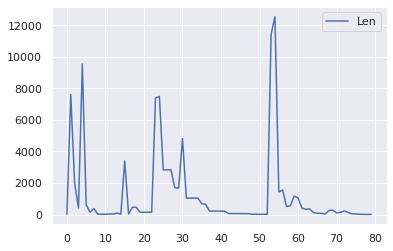

In [102]:
dim_and_len_df.plot()

In [103]:
# Remove all dim with len = 0
print(len(base_week))
for i in range(len(dim_and_len_df)):
  if dim_and_len_df.loc[i].Len==0:
    Process_Name=dim_and_len_df.loc[i].Process_Name
    Dim_name=dim_and_len_df.loc[i].Dim_name
    print(Process_Name,Dim_name)
    base_week[Process_Name].pop(Dim_name,None)
print(len(base_week))

34
34


# Calculate process indicator base on 25 lates subgroup sample

In [85]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472,
    16: 3.532,
    17:3.588,
    18:3.640,
    19:3.689,
    20:3.735,
}

In [86]:
def process_performance(data):
  df=data
  #print('dim: ',name)
  n=df.Date.value_counts()[0]
  num_sample=n*25
  df=df[-num_sample:]
  df=df.reset_index(drop=True)
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Value[-n:].mean() # only last day 

  #Ppk
  sigma=st.stdev(df.Value)
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  #print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
  #Cpk
  
  temp=df.groupby('Date').agg({'Value':['min','max']})
  temp['Range']=temp['Value','max']-temp['Value','min']
  Range=temp['Range'].mean()

  if n <= 20:
    sigma_within = Range/constants[n]
  else:
    sigma_within = Range/constants[20]

  Cp = float(usl - lsl) / (6*sigma_within)
  Cpu = float(usl - m) / (3*sigma_within)
  Cpl = float(m - lsl) / (3*sigma_within)
  Cpk = np.min([Cpu, Cpl])
  #print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
  if np.isnan(usl):
    Cpk=Cpl
    Ppk=Ppl
  elif np.isnan(lsl):
    Cpk=Cpu
    Ppk=Ppu
  else:
    Cpk = np.min([Cpu, Cpl])
    Ppk = np.min([Ppu, Ppl])
  #print(Ppk,Cpk)
  Cp=round(Cp,2)
  Cpk=round(Cpk,2)
  Pp=round(Pp,2)
  Ppk=round(Ppk,2)
  return Cp,Cpk,Pp,Ppk
 

In [87]:
process_indicator_dict={}
process_indicator_df=pd.DataFrame(columns=['Process_name','Dim_name','Cp','Pp','Cpk','Ppk'])
#process_indicator_df.columns=['Dim','Cp','Cpk','Pb','Ppk']
i=0
for process_name in list(base_week.keys()):
  #print(process_name)
  df_dict=base_week[process_name]
  for dim_name in list(df_dict.keys()): #also group
    #print(dim_name)
    df=df_dict[dim_name]
    #print(dim_name)
    #try: # object column cannot be calculated process indicator (OK, Not OK...) How to remove object colum in the beginning ?
    Cp,Cpk,Pp,Ppk=process_performance(df) 
    #except: continue
    #process_indicator_dict[process_name]=[dim_name,Cp,Pp,Cpk,Ppk]
    process_indicator_df.loc[i]=process_name,dim_name,Cp, Pp, Cpk, Ppk
    i+=1

process_indicator_df=process_indicator_df.sort_values(by='Ppk').reset_index(drop=True)

#conver process indicator dict to list name:
name_list_dict={} # key: process name, value: list all dim in process name

a=process_indicator_df
for process_name in list(base_week.keys()):
  dim_infor_string_list=[]
  for dim_name in list(base_week[process_name].keys()):
    dim_infor_string=str(dim_name) + ' Cp: ' + str(a[(a.Process_name==process_name) & (a.Dim_name==dim_name)]['Cp'].values[0]) + ' Pp: '+ \
    str(a[(a.Process_name==process_name) & (a.Dim_name==dim_name)]['Pp'].values[0]) +' Cpk: ' \
    + str(a[(a.Process_name==process_name) & (a.Dim_name==dim_name)]['Cpk'].values[0]) +' Ppk: '+ \
    str(a[(a.Process_name==process_name) & (a.Dim_name==dim_name)]['Ppk'].values[0]) 

    dim_infor_string_list.append(dim_infor_string)

  name_list_dict[process_name]=dim_infor_string_list
  #name_list.append(dim_name)

### Debug

In [ ]:
base_week.keys()

dict_keys(['39682', '38682', '30682', '37682', '30665', '30660-37660-38660', '30380-37380-38380', '37670-39670', '37662', '30650-37650 (3500T)', '37650-38655-39650', '37641', '30470-37470', '38546', '39615', '38940', '38594', '37640-38635', '30674-37674-38674 ', '30672-37672-38672', '30592', '30544-37544-38544-39544', '30538', '30530-37530-39530', '30480-37480-38481', '30370-37370-38370 ', '30750-30940-39750 _S1', '30750-30940-39750 _S2', '37750-37940_S1', '37750-37940_S2'])

In [ ]:
df=base_week['30750-30940-39750 _S2']['Spout  12-SN _ Connection strength']
df

,Date,Value,USL,LSL,UCL,LCL,Mean
0,2020-09-04 16:00:00,58.459999,NaN,50.0,60.991840,48.932159,54.962002
1,2020-09-04 16:00:00,55.740002,NaN,50.0,60.991840,48.932159,54.962002
2,2020-09-07 07:00:00,52.360001,NaN,50.0,60.991840,48.932159,54.962002
3,2020-09-07 07:00:00,54.189999,NaN,50.0,60.991840,48.932159,54.962002
4,2020-09-07 19:00:00,57.240002,NaN,50.0,60.991840,48.932159,54.962002
5,2020-09-07 19:00:00,53.160000,NaN,50.0,60.991840,48.932159,54.962002
6,2020-09-08 13:00:00,56.279999,NaN,50.0,60.991840,48.932159,54.962002
7,2020-09-08 13:00:00,54.169998,NaN,50.0,60.991840,48.932159,54.962002
8,2020-09-08 16:00:00,55.340000,NaN,50.0,60.991840,48.932159,54.962002
9,2020-09-08 16:00:00,52.680000,NaN,50.0,60.991840,48.932159,54.962002


In [ ]:
#print('dim: ',name)
df=base_week['30750-30940-39750 _S2']['Spout  12-SN _ Connection strength']
n=df.Date.value_counts()[0]
num_sample=n*25
df=df[-num_sample:]
df=df.reset_index(drop=True)
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Value[-n:].mean() # only last day 
print('usl:{:.2f} ,lsl: {:.2f}, m: {:.2f}'.format(usl,lsl,m))
#Ppk
sigma=st.stdev(df.Value)
print(sigma)
Pp = float(usl - lsl) / (6*sigma)
Ppu = float(usl - m) / (3*sigma)
Ppl = float(m - lsl) / (3*sigma)
Ppk = np.min([Ppu, Ppl])
#Cpk
temp=df.groupby('Date').agg({'Value':['min','max']})
temp['Range']=temp['Value','max']-temp['Value','min']
Range=temp['Range'].mean()

if n <= 20:
  sigma_within = Range/constants[n]
else:
  sigma_within = Range/constants[20]

Cp = float(usl - lsl) / (6*sigma_within)
Cpu = float(usl - m) / (3*sigma_within)
Cpl = float(m - lsl) / (3*sigma_within)
Cpk = np.min([Cpu, Cpl])
print('Ppu:{:.2f}'.format(Ppu))
print('Ppl:{:.2f}'.format(Ppl))
print('Cpu:{:.2f}'.format(Cpu))
print('Cpl:{:.2f}'.format(Cpl))
print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
Cp=round(Cp,2)
Cpk=round(Cpk,2)
Pp=round(Pp,2)
Ppk=round(Ppk,2)
if np.isnan(usl):
  Cpk=Cpl
  Ppk=Ppl
elif np.isnan(lsl):
  Cpk=Cpu
  Ppk=Ppu
else:
  Cpk = np.min([Cpu, Cpl])
  Ppk = np.min([Ppu, Ppl])
print(Ppk,Cpk)

 

usl:nan ,lsl: 50.00, m: 58.84
2.8058305955369924
Ppu:nan
Ppl:1.05
Cpu:nan
Cpl:1.68
Pp:nan , Ppk: nan
Cp:nan , Cpk:nan
1.0501940930490676 1.6756608299014177


In [ ]:

process_indicator_dict={}
process_indicator_df=pd.DataFrame(columns=['Dim','Cp','Pp','Cpk','Ppk'])
#process_indicator_df.columns=['Dim','Cp','Cpk','Pb','Ppk']
i=0
for process_name in list(base_week.keys()):
  print(process_name)
  df_dict=base_week[process_name]
  for dim_name in list(df_dict.keys()): #also group
    print(dim_name)
    df=df_dict[dim_name]
    #print(dim_name)
    #try: # object column cannot be calculated process indicator (OK, Not OK...) How to remove object colum in the beginning ?
    #Cp,Cpk,Pp,Ppk=process_performance(df) 

    #print('dim: ',name)
    n=df.Date.value_counts()[0]
    num_sample=n*25
    df=df[-num_sample:]
    df=df.reset_index(drop=True)
    usl=df.USL[0]
    lsl=df.LSL[0]
    m=df.Value[-n:].mean() # only last day 

    #Ppk
    sigma=st.stdev(df.Value)
    Pp = float(usl - lsl) / (6*sigma)
    Ppu = float(usl - m) / (3*sigma)
    Ppl = float(m - lsl) / (3*sigma)
    Ppk = np.min([Ppu, Ppl])
    #print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
    #Cpk

    temp=df.groupby('Date').agg({'Value':['min','max']})
    temp['Range']=temp['Value','max']-temp['Value','min']
    Range=temp['Range'].mean()

    if n <= 20:
      sigma_within = Range/constants[n]
    else:
      sigma_within = Range/constants[20]

    Cp = float(usl - lsl) / (6*sigma_within)
    Cpu = float(usl - m) / (3*sigma_within)
    Cpl = float(m - lsl) / (3*sigma_within)
    Cpk = np.min([Cpu, Cpl])
    #print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
    Cp=str(round(Cp,2))
    Cpk=str(round(Cpk,2))
    Pp=str(round(Pp,2))
    Ppk=str(round(Ppk,2))

    #except: continue
    process_indicator_dict[dim_name]=[Cp,Pp,Cpk,Ppk]
    process_indicator_df.loc[i]=dim_name,Cp, Pp, Cpk, Ppk
    i+=1


39682
Chiều rộng Dim E
Chiều dài Dim C
Cung hint Dim I
Cung J Dim J
Offset Dim M
38682
Hinge Dim F
Chiều dài Dim B
Chiều rộng Dim A
L.Tâm Dim N
Offset Dim M
Ba vớ trên membrane
30682
Hinge Dim F
Chiều dài Dim B
Chiều rộng Dim A
L.Tâm Dim N
Offset Dim M
Ba vớ trên membrane
37682
Offset Dim M
Ba vớ trên membrane
30665
30660 Độ sâu foil 
30660 Offset Dim M
37660 _3500T Độ sâu foil 
37660 _3500T Offset Dim M
37660  Độ sâu foil 
37660 Offset Dim M
38660  Độ sâu foil 
38660 Offset Dim M
30660-37660-38660
30660 Độ sâu foil 
30660 Offset Dim M
37660 _3500T Độ sâu foil 
37660 _3500T Offset Dim M
37660  Độ sâu foil 
37660 Offset Dim M
38660  Độ sâu foil 
38660 Offset Dim M
30380-37380-38380
3000 Dim A
3700 Dim A
3800 Dim A
37670-39670
3500T Đường kính lỗ bù (dim B)
3500T Vị trí của lỗ bù (dim A)
3900T Đường kính lỗ bù (dim B)
3900T Vị trí của lỗ bù (dim A)
37662
Kích thước lỗ drive pin (dim B)
Độ lệch tâm của lỗ drive pin (dim C)
Offset of membrane ( Dim D)
30650-37650 (3500T)
30650 Dim E
30650 

IndexError: ignored

### End debug

In [88]:
process_indicator_df

,Process_name,Dim_name,Cp,Pp,Cpk,Ppk
0,21660-21680-Dim-Offset E20,Dim A3,2.46,1.02,-0.29,-0.12
1,21660-21680-Dim-Offset E20,Dim B,2.65,0.97,-0.09,-0.03
2,21660-21680-Dim-Offset E45,Dim A2,1.71,0.65,-0.06,-0.02
3,21700-Dim E25-E20,Dim D,0.00,0.00,0.00,0.00
4,21660-21680-Dim-Offset E20,Dim A1,2.48,0.99,0.30,0.12
...,...,...,...,...,...,...
75,21660-21680-Dim-Offset E20,Dim A2,2.40,1.10,2.27,1.04
76,21920-Symmetry-SearforceSpoutLP,Dim A,1.34,1.23,1.16,1.06
77,21660-21680-Dim-Offset E25SH,Dim E,1.71,1.13,1.68,1.11
78,21660-21680-Dim-Offset E25SH,Dim B,2.35,1.52,1.76,1.14


In [89]:
process_indicator_df.dtypes

Process_name     object
Dim_name         object
Cp              float64
Pp              float64
Cpk             float64
Ppk             float64
dtype: object

In [90]:
def hightlight_price(row):
    ret = ["" for _ in row.index]
    if row.Cpk < limit or row.Ppk < limit:
      ret[row.index.get_loc("Process_name")] = "background-color: yellow"
      ret[row.index.get_loc("Dim_name")] = "background-color: yellow"
    if row.Cpk < limit:    
      ret[row.index.get_loc("Cpk")] = "background-color: yellow"
    if row.Ppk < limit:  
      ret[row.index.get_loc("Ppk")] = "background-color: yellow"
    return ret

limit = 1.33  # sigma: 4, Yield: 99.99%   
process_indicator_df.style.apply(hightlight_price, axis=1)

,Process_name,Dim_name,Cp,Pp,Cpk,Ppk
0,21660-21680-Dim-Offset E20,Dim A3,2.460000,1.020000,-0.290000,-0.120000
1,21660-21680-Dim-Offset E20,Dim B,2.650000,0.970000,-0.090000,-0.030000
2,21660-21680-Dim-Offset E45,Dim A2,1.710000,0.650000,-0.060000,-0.020000
3,21700-Dim E25-E20,Dim D,0.000000,0.000000,0.000000,0.000000
4,21660-21680-Dim-Offset E20,Dim A1,2.480000,0.990000,0.300000,0.120000
5,21660-21680-Dim-offset E25ST,Dim A2,0.990000,0.730000,0.160000,0.120000
6,21920-Symmetry-SearforceSpoutLP,Shear force,nan,nan,0.440000,0.120000
7,21660-21680-Dim-offset E25ST,Dim A3,1.060000,0.690000,0.200000,0.130000
8,21660-21680-Dim-Offset E45,Dim A3,1.890000,0.670000,0.380000,0.130000
9,21625-Dập core MB E25 SH,Dim A,1.110000,0.810000,0.190000,0.140000


nan value: missing USL or LSL

In [91]:
len(process_indicator_df)

80

In [92]:
len(name_list_dict) # equal to base week (all process in each weeks)

34

In [94]:
name_list_dict

{'21230-Ar 0.25': ['Dim A Cp: 0.68 Pp: 0.42 Cpk: 0.51 Ppk: 0.32'],
 '21230-Ar 0.26': ['Dim A Cp: 0.94 Pp: 0.58 Cpk: 0.83 Ppk: 0.52'],
 '21230-Ar 0.27': [],
 '21230-Ar 170um-0.25': ['Dim A Cp: 1.07 Pp: 0.67 Cpk: 0.99 Ppk: 0.62'],
 '21230-E40 Thickness': ['Độ dày Armature hàng E40 (BL)/\nArmature thickness E40 (BL) Cp: 2.33 Pp: 1.94 Cpk: 0.62 Ppk: 0.52'],
 '21425-E20S': ['Dim X Cp: 2.2 Pp: 0.73 Cpk: 0.76 Ppk: 0.25'],
 '21425-E25AE': [],
 '21425-E45': ['Dim B Cp: 2.46 Pp: 1.74 Cpk: 1.12 Ppk: 0.79'],
 '21425-E45 New': ['Dim H Cp: 2.26 Pp: 0.99 Cpk: 0.53 Ppk: 0.23'],
 '21425-Standard': ['Dim B Cp: 2.4 Pp: 1.82 Cpk: 1.66 Ppk: 1.26'],
 '21625-Dập core MB E25 SH': ['Dim A Cp: 1.11 Pp: 0.81 Cpk: 0.19 Ppk: 0.14',
  'Dim B Cp: 2.41 Pp: 0.83 Cpk: 0.79 Ppk: 0.27',
  'Dim E Cp: nan Pp: nan Cpk: 0.69 Ppk: 0.52'],
 '21635-Dán lỗi MB lên phôi E25SH': ['Dim A Cp: 0.79 Pp: 0.57 Cpk: 0.45 Ppk: 0.33',
  'Dim B Cp: nan Pp: nan Cpk: 0.96 Ppk: 0.69',
  'Connection Strength Cp: nan Pp: nan Cpk: 0.59 Ppk: 0.44'

## Line chart

### Try better method

In [93]:
for process_name in list(base_week.keys()):
  df_dict=base_week[process_name] # process name
  i=1
  #Layout
  fig = make_subplots(          # Dim name
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      #vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(name_list_dict[process_name]) # dict with key is process name and value is list of dim (contain name, cp, cpk...)
  )
  for name in list(df_dict.keys()): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    # Draw control chart
    df_group=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df_group.index, y=df_group['Value'],mode='lines+markers',
                            name='mean ', 
                            line=dict( color='#4280F5')
                            ),row=i, col=1)
    #USL, LSL
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['USL'],name='USL ', line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['LSL'],name='LSL ',line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['UCL'],name='UCL ', line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['LCL'],name='LCL ', line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['Mean'],name='Mean ', line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    i=i+1
  
  if len(df_dict)>1:
    fig.update_layout(height=200*len(df_dict), width=1200, title_text='Process: '+process_name)
  else:
    fig.update_layout(height=300, width=1200, title_text='Process: '+process_name)
  #fig update each process (contain a lot of dim inside)
  fig.show()
 

ValueError: ignored

### End better method

Original (stabel)

In [ ]:
for sheet_name in list(base_week.keys())[:3]:
  df_dict=base_week[sheet_name] # process

  i=1
  #Layout
  fig = make_subplots(              # all dim in each process
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      #vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    try:
      process_performance(df)
    except: 
      print('error calculate process performance')
    # Draw control chart
    df=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df.index, y=df['Value'],mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df.index, y=df['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df.index, y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['Mean'],name='Mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    i=i+1

  fig.update_layout(height=200*len(df_dict), width=1200, title_text='process '+sheet_name)
  fig.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Box plot chart

In [ ]:
for sheet_name in base_week.keys():
  df_dict=base_week[sheet_name]
    
  i=1
  #Layout
  fig = make_subplots(
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.set_index('Date')
    #Control chart 1 
    fig.append_trace(go.Box(
                            x=df.index, y=df['Value'],
                            name='mean ' + name, line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df.index, y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    i=i+1
    
  fig.update_layout(height=200*len(df_dict), width=1200, title_text=sheet_name)
  #fig.show()

## Py manufacturing

In [ ]:
for sheet_name in base_week.keys():
  print('process: ',sheet_name)
  df_dict=base_week[sheet_name]
  for name in df_dict.keys(): #also group
    print('dim: ',name)
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    try:
      #mn.control_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
      mn.ppk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
      mn.cpk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0],
              subgroup_size=df.Date.value_counts()[0])
    except:
      continue
   

## Calculate Cp/CpK/Ppk from base week (last week)

In [ ]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472,
    16: 3.532,
    17:3.588,
    18:3.640,
    19:3.689,
    20:3.735,
}

In [ ]:
import statistics as st
process_indicator={}
for process_name in base_week.keys():
  try:
    #print(process_name)
    process_dict=base_week[process_name]
    for dim in process_dict.keys():
      #print(dim)
      df=process_dict[dim]
      usl=df.USL[0]
      lsl=df.LSL[0]
      m=df.Mean[0]

      #Ppk
      sigma=st.stdev(df.Value)
      Pp = float(usl - lsl) / (6*sigma)
      Ppu = float(usl - m) / (3*sigma)
      Ppl = float(m - lsl) / (3*sigma)
      Ppk = np.min([Ppu, Ppl])
      #print('Pp',Pp)
      #print('Ppk',Ppk)

      #Cpk
      n=df.Date.value_counts()[0]
      temp=df.groupby('Date').agg({'Value':['min','max']})
      temp['R']=temp['Value','max']-temp['Value','min']
      R=temp['R'].mean()

      if n <= 20:
        sigma_within = R/constants[n]
      else:
        sigma_within = R/constants[20]
      
      Cp = float(usl - lsl) / (6*sigma_within)
      Cpu = float(usl - m) / (3*sigma_within)
      Cpl = float(m - lsl) / (3*sigma_within)
      Cpk = np.min([Cpu, Cpl])
      #print('Cp',Cp)
      #print('Cpk',Cpk)
  except:
    print('error:')
    print('process_name: ',process_name)
    print('dim: ',dim)
    continue

error:
process_name:  37670-39670
dim:  3500T Đường kính lỗ bù (dim B)
error:
process_name:  30470-37470
dim:  30470 Chiều dài drive pin sau khi cắt_Dim B 
error:
process_name:  38940
dim:  Spout 12-DL_ Vị trí C
error:
process_name:  30538
dim:  Lực của mối hàn
Welding spot strength
error:
process_name:  30750-30940-39750 _S1
dim:  Spout  1-SN_ Connection strength (3300U)
error:
process_name:  30750-30940-39750 _S2
dim:  Spout 12-DL (single)_ Connection strength 
error:
process_name:  37750-37940_S1
dim:  Spout  EL _ Vị trí C_11s
error:
process_name:  37750-37940_S2
dim:  Spout  1-SN (3700U) _ Connection strength


In [ ]:
import statistics as st
process_name='38682'
process_dict=base_week[process_name]
process_indicator={}
for dim in process_dict.keys():
  print(dim)
  df=process_dict[dim]
  # PPk"
  sigma=st.stdev(df.Value)
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Mean[0]
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  print('Pp',Pp)
  print('Ppk',Ppk)
  # CPK"
 

Hinge Dim F
Pp 0.8979230733571717
Ppk 0.7243247128588255
Chiều dài Dim B
Pp 0.611506076738254
Ppk 0.36690656193393173
Chiều rộng Dim A
Pp 0.5632059313075698
Ppk 0.5181419371853514
L.Tâm Dim N
Pp 1.4544298377882001
Ppk 0.8959287618724691
Offset Dim M
Pp nan
Ppk nan
Ba vớ trên membrane
Pp nan
Ppk nan


In [ ]:
 process_dict.keys()

dict_keys(['Hinge Dim F', 'Chiều dài Dim B', 'Chiều rộng Dim A', 'L.Tâm Dim N', 'Offset Dim M', 'Ba vớ trên membrane'])

In [ ]:
df=process_dict['Hinge Dim F']
df

,Date,Value,USL,LSL,UCL,LCL,Mean
0,2020-09-04 16:00:00,0.231,0.25,0.21,0.25614,0.211593,0.233867
1,2020-09-04 16:00:00,0.231,0.25,0.21,0.25614,0.211593,0.233867
2,2020-09-04 16:00:00,0.228,0.25,0.21,0.25614,0.211593,0.233867
3,2020-09-05 08:00:00,0.241,0.25,0.21,0.25614,0.211593,0.233867
4,2020-09-05 08:00:00,0.237,0.25,0.21,0.25614,0.211593,0.233867
5,2020-09-05 08:00:00,0.246,0.25,0.21,0.25614,0.211593,0.233867
6,2020-09-07 09:00:00,0.239,0.25,0.21,0.25614,0.211593,0.233867
7,2020-09-07 09:00:00,0.217,0.25,0.21,0.25614,0.211593,0.233867
8,2020-09-07 09:00:00,0.242,0.25,0.21,0.25614,0.211593,0.233867
9,2020-09-08 10:00:00,0.232,0.25,0.21,0.25614,0.211593,0.233867


3

In [ ]:
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Mean[0]

In [ ]:
temp=df.groupby('Date').agg({'Value':['min','max']})
temp

Value       
                       min    max
Date                             
2020-09-04 16:00:00  0.228  0.231
2020-09-05 08:00:00  0.237  0.246
2020-09-07 09:00:00  0.217  0.242
2020-09-08 10:00:00  0.230  0.240
2020-09-08 16:00:00  0.225  0.235

In [ ]:
temp.columns

MultiIndex([('Value', 'min'),
            ('Value', 'max')],
           )

In [ ]:
temp['Value','min']

Date
2020-09-04 16:00:00    0.228
2020-09-05 08:00:00    0.237
2020-09-07 09:00:00    0.217
2020-09-08 10:00:00    0.230
2020-09-08 16:00:00    0.225
Name: (Value, min), dtype: float32

In [ ]:
temp['R']=temp['Value','max']-temp['Value','min']

In [ ]:
temp

Value             R
                       min    max       
Date                                    
2020-09-04 16:00:00  0.228  0.231  0.003
2020-09-05 08:00:00  0.237  0.246  0.009
2020-09-07 09:00:00  0.217  0.242  0.025
2020-09-08 10:00:00  0.230  0.240  0.010
2020-09-08 16:00:00  0.225  0.235  0.010

In [ ]:
R=temp['R'].mean()
R

0.011400002054870129

In [ ]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472
}

In [ ]:
n=df.Date.value_counts()[0]
sigma_within=R/constants[n]
sigma_within

0.006733610191890211

In [ ]:
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Mean[0]
Cp = float(usl - lsl) / (6*sigma_within)
Cpu = float(usl - m) / (3*sigma_within)
Cpl = float(m - lsl) / (3*sigma_within)
Cpk = np.min([Cpu, Cpl])
print('Cp',Cp)
print('Cpk',Cpk)

sigma=st.stdev(df.Value)
Pp = float(usl - lsl) / (6*sigma)
Ppu = float(usl - m) / (3*sigma)
Ppl = float(m - lsl) / (3*sigma)
Ppk = np.min([Ppu, Ppl])
print('Pp',Pp)
print('Ppk',Ppk)

Cp 0.9900584633556088
Cpk 0.7986472710878285
Pp 0.8979230733571717
Ppk 0.7243247128588255


In [ ]:
#!pip install manufacturing

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



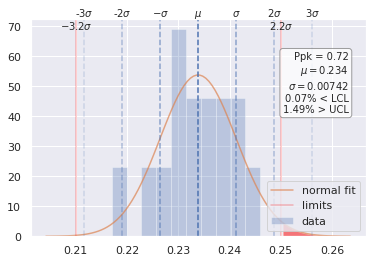

In [ ]:
import manufacturing as mn
mn.ppk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])

shapiro test indicates that the distribution is NOT normal
skewtest is not valid with less than 8 samples; 3 samples were given.
the data set is most likely not normally distributed
skewtest is not valid with less than 8 samples; 3 samples were given.
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits
skewtest is not valid with less than 8 samples; 3 samples were given.
skewtest is not valid with less than 8 samples; 3 samples were given.
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits
skewtest is not valid with less than 8 samples; 3 samples were given.
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



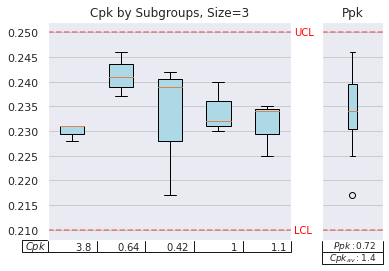

In [ ]:
mn.cpk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0],
            subgroup_size=3)

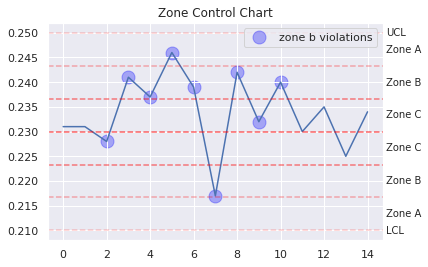

In [ ]:
mn.control_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
# Khong group df ở đây